## <b><font color='darkblue'>Preface</font></b>
([source](https://courses.dataschool.io/view/courses/build-ai-agents-with-python/3021205-chapter-4-updating-the-app-with-real-time-search/9969491-resetting-the-workflow-and-chatbot))

### <b><font color='darkgreen'>Section 1,2: Binds tools to model</font></b>
([source1](https://courses.dataschool.io/view/courses/build-ai-agents-with-python/3021205-chapter-4-updating-the-app-with-real-time-search/9969491-resetting-the-workflow-and-chatbot), [source2](https://courses.dataschool.io/view/courses/build-ai-agents-with-python/3021205-chapter-4-updating-the-app-with-real-time-search/9969947-creating-a-search-tool))
* [**Tools** (LangChain documentation)](https://python.langchain.com/docs/integrations/tools/)
* [**Tavily Search**](https://tavily.com/)

In [2]:
import getpass
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate

_ = load_dotenv()

In [3]:
prompt = ChatPromptTemplate([
    ('system', 'Limit all of your responses to two sentences.'),
    ("placeholder", "{messages}"),
])

model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

chain = prompt | model

In [4]:
def call_model(state: MessagesState, chain=chain):
    updated_messages = chain.invoke(state["messages"])
    return {"messages": updated_messages}

workflow = StateGraph(MessagesState)
workflow.add_node("model_node", call_model)
workflow.add_edge(START, "model_node")

memory = MemorySaver()
app = workflow.compile(memory)

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults(max_results=5)

In [6]:
search.description

'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.'

In [7]:
search.name

'tavily_search_results_json'

In [6]:
tool_list = [search]
model_with_tools = model.bind_tools(tool_list)

### <b><font color='darkgreen'>Section: Adding search to the workflow</font></b>
([source](https://courses.dataschool.io/view/courses/build-ai-agents-with-python/3021205-chapter-4-updating-the-app-with-real-time-search/9970752-adding-search-to-the-workflow))

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition

call_tool = ToolNode(tool_list)

In [8]:
workflow = StateGraph(MessagesState)

In [9]:
workflow.add_node("model_node", call_model)
workflow.add_node("tools", call_tool)

In [10]:
workflow.add_edge(START, "model_node")
workflow.add_conditional_edges("model_node", tools_condition)
workflow.add_edge("tools", "model_node")

In [11]:
memory = MemorySaver()
app = workflow.compile(memory)

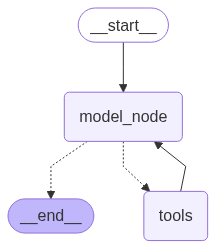

In [12]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

### <b><font color='darkgreen'>Section: Reviewing the tool-based workflow</font></b>
([source](https://courses.dataschool.io/view/courses/build-ai-agents-with-python/3021205-chapter-4-updating-the-app-with-real-time-search/9973992-reviewing-the-tool-based-workflow))
* [**create_react_agent** (LangGraph API reference)](https://langchain-ai.github.io/langgraph/reference/prebuilt/)

In [13]:
prompt = ChatPromptTemplate([
    ('system', 'Limit all of your responses to two sentences.'),
    ("placeholder", "{messages}"),
])

model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
).bind_tools(tool_list)

chain = prompt | model

def call_model(state: MessagesState, model=model):
    updated_messages = model.invoke(state["messages"])
    return {"messages": updated_messages}

In [14]:
tool_list = [TavilySearchResults(max_results=5)]
call_tool = ToolNode(tool_list)
workflow = StateGraph(MessagesState)

In [15]:
workflow.add_node("model_node", call_model)
workflow.add_node("tools", call_tool)
workflow.add_edge(START, "model_node")
workflow.add_conditional_edges("model_node", tools_condition)
workflow.add_edge("tools", "model_node")

memory = MemorySaver()
app = workflow.compile(memory)

In [16]:
def chatbot(chat_id: int=123, app=app):
    config = {"configurable": {"thread_id": chat_id}}

    while True:
        user_input = input("User:")

        if user_input in ["exit", "quit"]:
            print("AI: See you later!")
            break
        
        else:
            print("AI: ", end="")
            for chunk, metadata in app.stream({"messages": user_input}, config, stream_mode="messages"):
                print(chunk.content, end="", flush=True)
            print("\n")

### <b><font color='darkgreen'>Section: Showing the search URLs</font></b>
([source](https://courses.dataschool.io/view/courses/build-ai-agents-with-python/3021205-chapter-4-updating-the-app-with-real-time-search/9974318-showing-the-search-urls))

In [43]:
chatbot()

User: List me the first five president of the US.


AI: 1. George Washington
2. John Adams
3. Thomas Jefferson
4. James Madison
5. James Monroe




User: What is the latest version of Gemini?


AI: [{"title": "Gemini models | Gemini API | Google AI for Developers", "url": "https://ai.google.dev/gemini-api/docs/models", "content": "Read the model version patterns for more details. Latest: gemini-1.5-flash-latest; Latest stable: gemini-1.5-flash; Stable: gemini-1.5-flash-001; gemini-1.5", "score": 0.78493005}, {"title": "Introducing Gemini 2.0: our new AI model for the agentic era", "url": "https://blog.google/technology/google-deepmind/google-gemini-ai-update-december-2024/", "content": "Since we introduced [Project Astra](https://deepmind.google/technologies/gemini/project-astra/) at I/O, we’ve been learning from trusted testers using it on Android phones. Their valuable feedback has helped us better understand how a universal AI assistant could work in practice, including implications for safety and ethics. Improvements in the latest version built with Gemini 2.0 include: [...] * Google DeepMind introduces Gemini 2.0, a new AI model designed for the \"agentic era.\"\n* Gemin

User: exit


AI: See you later!


Let's modify our `chatbot` for different messages [**AIMessage**](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.ai.AIMessage.html) and [**ToolMessage**](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.tool.ToolMessage.html)

In [18]:
import json
from langchain_core.messages import AIMessage, ToolMessage

In [23]:
def chatbot(chat_id: int=123, app=app):
    config = {"configurable": {"thread_id": chat_id}}

    while True:
        user_input = input("User:")

        if user_input in ["exit", "quit"]:
            print("AI: See you later!")
            break
        
        else:
            print("AI: ", end="")
            for chunk, metadata in app.stream({"messages": user_input}, config, stream_mode="messages"):
                if isinstance(chunk, AIMessage):
                    print(chunk.content, end="", flush=True)
                if isinstance(chunk, ToolMessage):
                    #print(f'Tool message:\n{chunk.content}\n\n')
                    result_list = json.loads(chunk.content)
                    urls = [f'- {result['url']}' for result in result_list]
                    print(f'\nReferences:')
                    print('\n'.join(urls), end='', flush=True)
                    print('\n\n')
            print("\n")

In [24]:
chatbot()

User: What is the latest version of Gemini?


AI: 
References:
- https://ai.google.dev/gemini-api/docs/models
- https://gemini.google.com/updates
- https://ai.google.dev/gemini-api/docs/changelog
- https://blog.google/products/gemini/gemini-2-5-pro-updates/
- https://blog.google/technology/google-deepmind/google-gemini-updates-io-2025/


Based on the search results, the latest version of Gemini is Gemini 2.5 Pro. Other recent versions include Gemini 2.0 Flash, Gemini 1.5 Pro, and Gemini 1.5 Flash.




User: exit


AI: See you later!


### <b><font color='darkgreen'>Section: Examining the tool calls</font></b>
([source](https://courses.dataschool.io/view/courses/build-ai-agents-with-python/3021205-chapter-4-updating-the-app-with-real-time-search/9974456-examining-the-tool-calls))

In [27]:
def examine_chatbot(chat_id: int=123, app=app):
    config = {"configurable": {"thread_id": chat_id}}

    while True:
        user_input = input("User:")

        if user_input in ["exit", "quit"]:
            print("AI: See you later!")
            break
        
        else:
            print("AI: ", end="")
            for state in app.stream({"messages": user_input}, config, stream_mode="values"):
                message = state['messages'][-1]
                message.pretty_print()
            print("\n")

In [28]:
examine_chatbot()

User: What is the latest version of Gemini?


AI: ================================ Human Message =================================

What is the latest version of Gemini?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (d2824e78-8e8f-4252-bab9-0d9eccfa227f)
 Call ID: d2824e78-8e8f-4252-bab9-0d9eccfa227f
  Args:
    query: latest version of Gemini
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Gemini models | Gemini API | Google AI for Developers", "url": "https://ai.google.dev/gemini-api/docs/models", "content": "123Versions, Read the model version patterns for more details. Latest: gemini-1.5-pro-latest; Latest stable: gemini-1.5-pro; Stable: gemini-1.5-pro-001; gemini-", "score": 0.83225065}, {"title": "Release notes | Gemini API | Google AI for Developers", "url": "https://ai.google.dev/gemini-api/docs/changelog", "content": "Released gemini-1.5-pro-002 and gemini-1.5-flash-002

User: exit


AI: See you later!
